# Quickstart Example with Multi-class Classificatoin Data
---
This notebook provides an example of conducting OPE of an evaluate policy using multi-class classification dataset as logged bandit feedback data.

Our example with multi-class classification data contains the follwoing four major steps:
- (1) Bandit Reduction
- (2) Off-Policy Learning
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [../examples/multiclass](../examples/multiclass) for a more sophisticated example of the evaluation of OPE with multi-class classification datasets.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
import obp
from obp.dataset import MultiClassToBanditReduction
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

In [2]:
# obp version
print(obp.__version__)

0.3.3


## (1) Bandit Reduction
We prepare easy-to-use interface for bandit reduction of multi-class classificatoin dataset: `MultiClassToBanditReduction` class in the dataset module.

It takes feature vectors (`X`), class labels (`y`), classifier to construct behavior policy (`base_classifier_b`), paramter of behavior policy (`alpha_b`) as inputs and generates a bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [3]:
# load raw digits data
# `return_X_y` splits feature vectors and labels, instead of returning a Bunch object
X, y = load_digits(return_X_y=True)

# convert the raw classification data into a logged bandit dataset
# we construct a behavior policy using Logistic Regression and parameter alpha_b
# given a pair of a feature vector and a label (x, c), create a pair of a context vector and reward (x, r)
# where r = 1 if the output of the behavior policy is equal to c and r = 0 otherwise
# please refer to https://zr-obp.readthedocs.io/en/latest/_autosummary/obp.dataset.multiclass.html for the details
dataset = MultiClassToBanditReduction(
    X=X,
    y=y,
    base_classifier_b=LogisticRegression(max_iter=1000, random_state=12345),
    alpha_b=0.8,
    dataset_name="digits",
)
# split the original data into training and evaluation sets
dataset.split_train_eval(eval_size=0.7, random_state=12345)
# obtain logged bandit feedback generated by behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=12345)

# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback

{'n_actions': 10,
 'n_rounds': 1258,
 'context': array([[ 0.,  0.,  0., ..., 16.,  1.,  0.],
        [ 0.,  0.,  7., ..., 16.,  3.,  0.],
        [ 0.,  0., 12., ...,  8.,  0.,  0.],
        ...,
        [ 0.,  1., 13., ...,  8., 11.,  1.],
        [ 0.,  0., 15., ...,  0.,  0.,  0.],
        [ 0.,  0.,  4., ..., 15.,  3.,  0.]]),
 'action': array([6, 8, 5, ..., 2, 5, 9]),
 'reward': array([1., 1., 1., ..., 1., 1., 1.]),
 'position': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.82, 0.82, 0.82, ..., 0.82, 0.82, 0.82])}

## (2) Off-Policy Learning
After generating logged bandit feedback, we now obtain an evaluation policy using the training set. <br>

In [4]:
# obtain action choice probabilities by an evaluation policy
# we construct an evaluation policy using Random Forest and parameter alpha_e
action_dist = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForest(random_state=12345),
    alpha_e=0.9,
)

## (3) Off-Policy Evaluation (OPE)
OPE attempts to estimate the performance of evaluation policies using their action choice probabilities.

Here, we use the **InverseProbabilityWeighting (IPW)**, **DirectMethod (DM)**, and **Doubly Robust (DR)** estimators and visualize the OPE results.

In [5]:
# estimate the mean reward function by using ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=LogisticRegression(random_state=12345, max_iter=1000),
)
# please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [6]:
# estimate the policy value of the evaluation policy based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.890339          0.826724          0.975248
dm   0.787085          0.779634          0.793370
dr   0.882536          0.808637          0.937305 



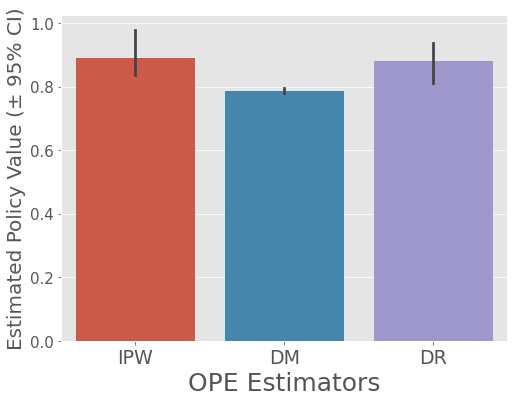

In [7]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval, '\n')
# visualize estimated policy values of the evaluation policy with Logistic Regression by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With the multi-class classification data, we can calculate the ground-truth policy value of the evaluation policy. 
Therefore, we can compare the policy values estimated by OPE estimators with the ground-turth to evaluate OPE estimators.

In [8]:
# calculate the ground-truth performance of the evaluation policy
ground_truth = dataset.calc_ground_truth_policy_value(action_dist=action_dist)

print(f'ground-truth policy value (classification accuracy): {ground_truth}')

ground-truth policy value: 0.8770906200317964


In [9]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy value of the evaluation policy and its ground-truth.
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee

,relative-ee
ipw,0.015030
dm,0.102252
dr,0.002656


Please see [../examples/multiclass](../examples/multiclass) for a more sophisticated example of the evaluation of OPE with multi-class classification data.